In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import math
import re
import datetime
import numpy as np
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
mpl.rcParams['font.family'] = 'IPAGothic'
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import matplotlib.cm as mplcm
%matplotlib inline
import pandas as pd
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
import sklearn.preprocessing as skpp
import tensorflow as tf
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import jpholiday

In [2]:
first_day=datetime.date(2020,1,1)
today=datetime.date.today()
all_ages=['不明','0',]+[str(i)+'0' for i in range(1,10)]
prefectures=[
    '北海道',
    '宮城県','秋田県','福島県','青森県','山形県','岩手県',
    '東京都','神奈川県','千葉県','埼玉県','栃木県','群馬県','茨城県',
    '石川県','愛知県','長野県','岐阜県','静岡県','新潟県','山梨県','福井県','富山県',
    '大阪府','奈良県','三重県','京都府','和歌山県','兵庫県','滋賀県',
    '山口県','広島県','岡山県','島根県','鳥取県',
    '徳島県','高知県','愛媛県','香川県',
    '福岡県','熊本県','沖縄県','大分県','宮崎県','佐賀県','長崎県','鹿児島県',
    '中部国際空港','羽田空港','成田空港','関西国際空港',
    '不明'
]
populations={
    '北海道':532.0,
    '青森県':127.8,'岩手県':125.5,'宮城県':232.3,'秋田県':99.6,'山形県':110.2,'福島県':188.2,
    '茨城県':289.2,'栃木県':195.7,'群馬県':196.0,'埼玉県':731.0,'千葉県':624.6,'東京都':1372.4,'神奈川県':915.9,
    '新潟県':226.7,'富山県':105.6,'石川県':114.7,'福井県':77.9,'山梨県':82.3,'長野県':207.6,'岐阜県':200.8,'静岡県':367.5,'愛知県':752.5,
    '三重県':180.0,'滋賀県':141.3,'京都府':259.9,'大阪府':882.3,'兵庫県':550.3,'奈良県':134.8,'和歌山県':94.5,
    '鳥取県':56.5,'島根県':68.5,'岡山県':190.7,'広島県':282.9,'山口県':138.3,
    '徳島県':74.3,'香川県':96.7,'愛媛県':136.4,'高知県':71.4,
    '福岡県':510.7,'佐賀県':82.4,'長崎県':135.4,'熊本県':176.5,'大分県':115.2,'宮崎県':108.9,'鹿児島県':162.6,'沖縄県':144.3,
}


url='https://dl.dropboxusercontent.com/s/6mztoeb6xf78g5w/COVID-19.csv'
df=pd.read_csv(url)
new_df=df.copy()
new_df['確定日']=pd.to_datetime(df['確定日'])
new_df['発症日']=pd.to_datetime(df['発症日'])
new_df['発症から確定までの日数']=(new_df['確定日']-new_df['発症日']).dt.days


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date+datetime.timedelta(n)


def isHoliday(date):
    if date.weekday()>=5 or jpholiday.is_holiday(date):
        return True
    else:
        return False


column_list=['曜日','土日祝',]
for ages in all_ages:
    for location in prefectures:
        for sex in ['男性','女性','不明']:
            for data in ['確定数','発症数']:
                column_list+=[f'{ages}歳代{sex}({location}){data}',]

data_df=pd.DataFrame()
for day in daterange(first_day,today):
    data_df.loc[str(day),'曜日']=day.weekday()
    if isHoliday(day):
        data_df.loc[str(day),'土日祝']=1
    else:
        data_df.loc[str(day),'土日祝']=0
new_df=new_df.replace({'年代':'0-10'},'0').replace({'年代':'未就学児'},'0')
for ages in [str(i)+'0' for i in range(1,10)]:
    new_df=new_df.replace({'年代':ages+' '},ages)
data1_df=new_df[['確定日','年代','受診都道府県','性別',]].pivot_table(index=['確定日',],columns=['年代','受診都道府県','性別',],aggfunc=len,fill_value=0)
data2_df=new_df[['発症日','年代','受診都道府県','性別',]].pivot_table(index=['発症日',],columns=['年代','受診都道府県','性別',],aggfunc=len,fill_value=0)
out_columns=[]
out_columns+=[f'{column[0]}歳代{column[2]}({column[1]})確定数' for column in data1_df.columns]
out_columns+=[f'{column[0]}歳代{column[2]}({column[1]})発症数' for column in data2_df.columns]
data1_df.columns=[f'{column[0]}歳代{column[2]}({column[1]})確定数' for column in data1_df.columns]
data2_df.columns=[f'{column[0]}歳代{column[2]}({column[1]})発症数' for column in data2_df.columns]
data_df=data_df.join(data1_df,how='outer').join(data2_df,how='outer')
data_df=data_df.reindex(column_list,axis='columns').reindex([day for day in daterange(first_day,today)]).fillna(0)
for column in data_df.columns:
    matches=re.search(r'\((.+)\)',column)
    if matches:
        location=matches.group(1)
        if location in populations:
            data_df[column+'人口あたり']=data_df[column]/populations[location]
display(data_df)


/home/matsuoka/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,3,4,16,31,32,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


曜日  土日祝  不明歳代男性(北海道)確定数  不明歳代男性(北海道)発症数  不明歳代女性(北海道)確定数  \
2020-01-01  2.0  1.0             0.0             0.0             0.0   
2020-01-02  3.0  0.0             0.0             0.0             0.0   
2020-01-03  4.0  0.0             0.0             0.0             0.0   
2020-01-04  5.0  1.0             0.0             0.0             0.0   
2020-01-05  6.0  1.0             0.0             0.0             0.0   
...         ...  ...             ...             ...             ...   
2020-08-20  3.0  0.0             0.0             0.0             0.0   
2020-08-21  4.0  0.0             0.0             0.0             1.0   
2020-08-22  5.0  1.0             0.0             0.0             0.0   
2020-08-23  6.0  1.0             0.0             0.0             0.0   
2020-08-24  0.0  0.0             0.0             0.0             0.0   

            不明歳代女性(北海道)発症数  不明歳代不明(北海道)確定数  不明歳代不明(北海道)発症数  不明歳代男性(宮城県)確定数  \
2020-01-01             0.0             0.0             0.0             0.0   
2020-01-02             0.0             0.0             0.0             0.0   
2020-01-03             0.0             0.0             0.0             0.0   
2020-01-04             0.0             0.0             0.0             0.0   
2020-01-05             0.0             0.0             0.0             0.0   
...                    ...             ...             ...             ...   
2020-08-20             0.0             0.0             0.0             0.0   
2020-08-21             0.0             3.0             0.0             0.0   
2020-08-22             0.0             1.0             0.0             0.0   
2020-08-23             0.0             0.0             0.0             0.0   
2020-08-24             0.0             0.0             0.0             0.0   

            不明歳代男性(宮城県)発症数  ...  90歳代女性(長崎県)確定数人口あたり  90歳代女性(長崎県)発症数人口あたり  \
2020-01-01             0.0  ...                  0.0                  0.0   
2020-01-02             0.0  ...                  0.0                  0.0   
2020-01-03             0.0  ...                  0.0                  0.0   
2020-01-04             0.0  ...                  0.0                  0.0   
2020-01-05             0.0  ...                  0.0                  0.0   
...                    ...  ...                  ...                  ...   
2020-08-20             0.0  ...                  0.0                  0.0   
2020-08-21             0.0  ...                  0.0                  0.0   
2020-08-22             0.0  ...                  0.0                  0.0   
2020-08-23             0.0  ...                  0.0                  0.0   
2020-08-24             0.0  ...                  0.0                  0.0   

            90歳代不明(長崎県)確定数人口あたり  90歳代不明(長崎県)発症数人口あたり  90歳代男性(鹿児島県)確定数人口あたり  \
2020-01-01                  0.0                  0.0                   0.0   
2020-01-02                  0.0                  0.0                   0.0   
2020-01-03                  0.0                  0.0                   0.0   
2020-01-04                  0.0                  0.0                   0.0   
2020-01-05                  0.0                  0.0                   0.0   
...                         ...                  ...                   ...   
2020-08-20                  0.0                  0.0                   0.0   
2020-08-21                  0.0                  0.0                   0.0   
2020-08-22                  0.0                  0.0                   0.0   
2020-08-23                  0.0                  0.0                   0.0   
2020-08-24                  0.0                  0.0                   0.0   

            90歳代男性(鹿児島県)発症数人口あたり  90歳代女性(鹿児島県)確定数人口あたり  90歳代女性(鹿児島県)発症数人口あたり  \
2020-01-01                   0.0                   0.0                   0.0   
2020-01-02                   0.0                   0.0                   0.0   
2020-01-03                   0.0                   0.0                   0.0   
2020-01-04                   

In [3]:
n_sequence=100
n_batch_size=30
n_epochs=500
n_hidden=50
n_earlystopping=30
forecasting_days=100


def make_dataset(in_np,out_np,lag_days):
    total_days=in_np.shape[0]
    in_features=in_np.shape[1]
    out_features=out_np.shape[1]
    in_data=[]
    out_data=[]
    for i in range(total_days-lag_days):
        in_data.append(in_np[i:i+lag_days,:])
        out_data.append(out_np[i+lag_days,:])
    in_data_np=np.array(in_data).reshape(total_days-lag_days,lag_days,in_features)
    out_data_np=np.array(out_data).reshape(total_days-lag_days,out_features)
    return in_data_np,out_data_np


data_columns=data_df.columns
in_np=np.array(data_df[data_columns],dtype=np.float16)
out_np=np.array(data_df[out_columns],dtype=np.float16)
in_scaler=skpp.StandardScaler()
scaled_in_np=in_scaler.fit_transform(in_np)
out_scaler=skpp.StandardScaler()
scaled_out_np=out_scaler.fit_transform(out_np)
in_data,out_data=make_dataset(scaled_in_np,scaled_out_np,n_sequence)


model=tf.keras.Sequential([
    tf.keras.layers.LSTM(
        n_hidden,
        batch_input_shape=(None,in_data.shape[1],in_data.shape[2]),
        return_sequences=False
    ),
    #tf.keras.layers.Dense(300,activation=tf.keras.layers.ReLU()),
    #tf.keras.layers.Dense(300,activation=tf.keras.layers.ReLU()),
    #tf.keras.layers.Dense(300,activation=tf.keras.layers.ReLU()),
    #tf.keras.layers.Dense(300,activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Dense(out_data.shape[1],activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    #tf.keras.layers.Dense(out_data.shape[1],activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(out_data.shape[1],activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
])
model.compile(loss=tf.keras.losses.MeanAbsoluteError(),optimizer=tf.keras.optimizers.Adam())
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto',patience=n_earlystopping)
model.fit(
    in_data,
    out_data,
    batch_size=n_batch_size,
    epochs=n_epochs,
    validation_split=0.1,
    callbacks=[early_stopping],
)
scaled_pred_data_np=model.predict(in_data)
pred_data_np=out_scaler.inverse_transform(scaled_pred_data_np)
pred_df=data_df.copy()
pred_df.loc[pred_df.index[-pred_data_np.shape[0]:],out_columns]=pred_data_np

for current_date in daterange(today,today+datetime.timedelta(forecasting_days)):
    pred_columns=pred_df.columns
    last_np=np.array(pred_df[pred_columns],dtype=np.float16)[-n_sequence:,:]
    last_data=in_scaler.fit_transform(last_np)[None,:,:]
    print(f'predicting {str(current_date)}')
    scaled_pred_data_np=model.predict(last_data)
    pred_data_np=out_scaler.inverse_transform(scaled_pred_data_np)
    pred_df.loc[str(current_date),out_columns]=pred_data_np
    pred_df.loc[str(current_date),'曜日']=current_date.weekday()
    if isHoliday(current_date):
        pred_df.loc[str(current_date),'土日祝']=1
    else:
        pred_df.loc[str(current_date),'土日祝']=0
    for column in pred_df.columns:
        if '人口あたり' in column:
            matches=re.search(r'\((.+)\)',column)
            location=matches.group(1)
            pred_df.loc[str(current_date),column]=pred_df.loc[str(current_date),column[:-5]]/populations[location]
    pred_df=pred_df.fillna(0)

Train on 123 samples, validate on 14 samples
Epoch 1/500
123/123 [==============================] - 4s 29ms/sample - loss: 0.4075 - val_loss: 0.5388
Epoch 2/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.3981 - val_loss: 0.5297
Epoch 3/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.3929 - val_loss: 0.5349
Epoch 4/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.3883 - val_loss: 0.5386
Epoch 5/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.3840 - val_loss: 0.5391
Epoch 6/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.3796 - val_loss: 0.5331
Epoch 7/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.3739 - val_loss: 0.5225
Epoch 8/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.3662 - val_loss: 0.5160
Epoch 9/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.3530 - val_loss: 0.5073
Epoch 10/500
123/123 [=====

123/123 [==============================] - 0s 1ms/sample - loss: 0.2355 - val_loss: 0.4520
Epoch 80/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.2354 - val_loss: 0.4472
Epoch 81/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.2340 - val_loss: 0.4491
Epoch 82/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.2343 - val_loss: 0.4462
Epoch 83/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.2344 - val_loss: 0.4460
Epoch 84/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.2342 - val_loss: 0.4464
Epoch 85/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.2336 - val_loss: 0.4497
Epoch 86/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.2342 - val_loss: 0.4464
Epoch 87/500
123/123 [==============================] - 0s 1ms/sample - loss: 0.2341 - val_loss: 0.4473
Epoch 88/500
123/123 [==============================] - 0s 1ms/sample - loss:

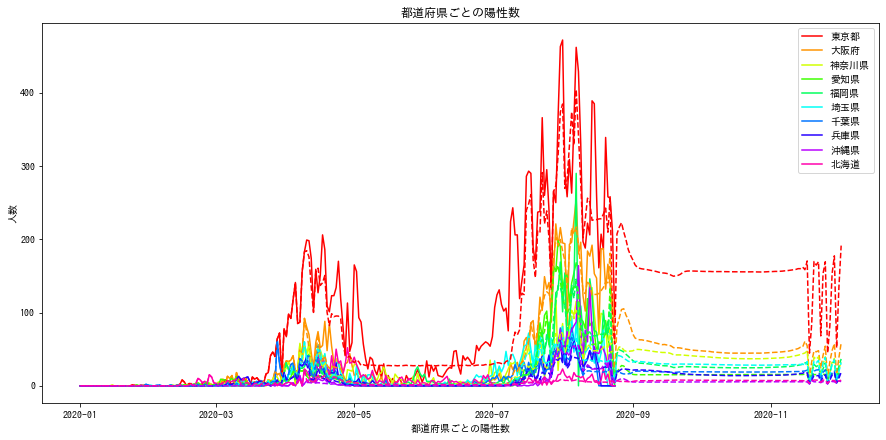

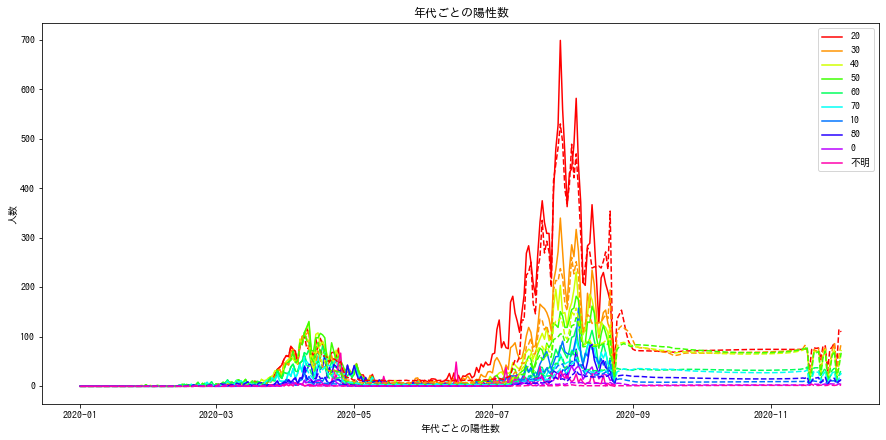

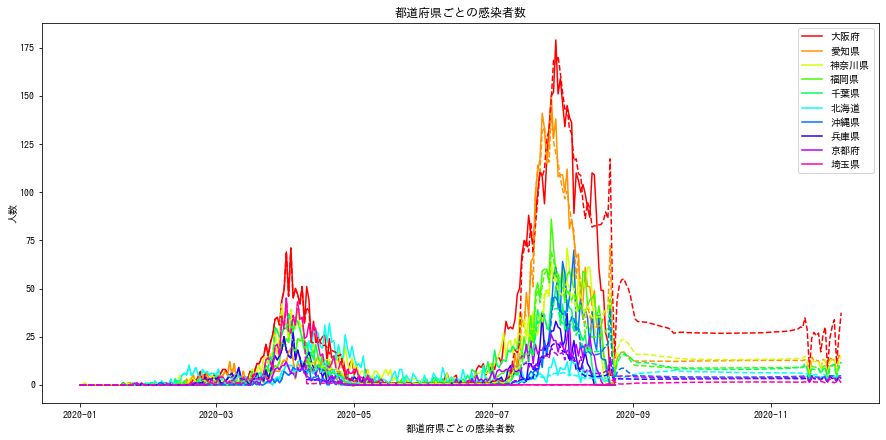

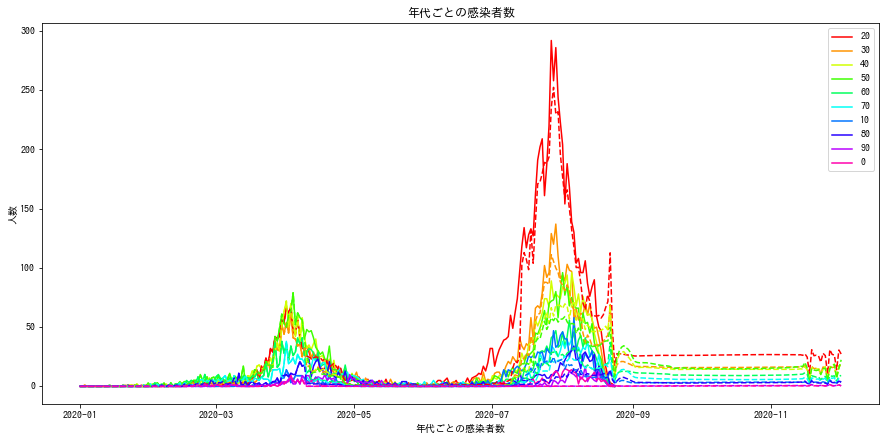

In [4]:
def show_mult_plot(df1,df2,x_ages,x_location,x_sex,x_data,title,top=10):
    if x_ages==None:
        ages_set=all_ages
    elif isinstance(x_ages,str):
        ages_set=[x_ages,]
    else:
        ages_set=x_ages
    if x_location==None:
        location_set=prefectures
    elif isinstance(x_location,str):
        location_set=[x_location,]
    else:
        location_set=x_location
    if x_sex==None:
        sex_set=['男性','女性','不明']
    elif isinstance(x_sex,str):
        sex_set=[x_sex,]
    else:
        sex_set=x_sex
    categories={}
    for ages in ages_set:
        if not (isinstance(x_ages,list) and ages not in x_ages):
            if isinstance(x_ages,list):
                current_category=ages
            for location in location_set:
                if not (isinstance(x_location,list) and location not in x_location):
                    if isinstance(x_location,list):
                        current_category=location
                for sex in sex_set:
                    if not (isinstance(x_sex,list) and sex not in x_sex):
                        if isinstance(x_sex,list):
                            current_category=sex
                        if current_category not in categories:
                            categories[current_category]=[]
                        label=f'{ages}歳代{sex}({location}){x_data}'
                        categories[current_category]+=[label,]
    fig,ax=plt.subplots(figsize=(15,7))
    sum_y={}
    for category in categories:
        labels=categories[category]
        sum_y[category]=np.array(df1[labels].sum(axis=1)).sum()
    top_categories=[key for key,_ in sorted(sum_y.items(),key=lambda x:x[1], reverse=True)]
    x1_values=[day for day in daterange(first_day,today)]
    x2_values=[day for day in daterange(first_day,today+datetime.timedelta(forecasting_days))]
    for i_category,category in enumerate(top_categories[:top]):
        labels=categories[category]
        y_values=np.array(df1[labels].sum(axis=1))
        ax.plot(x1_values,y_values,'-',label=str(category),color=mplcm.hsv(i_category/top))
    for i_category,category in enumerate(top_categories[:top]):
        labels=categories[category]
        y_values=np.array(df2[labels].sum(axis=1))
        ax.plot(x2_values,y_values,'--',color=mplcm.hsv(i_category/top))
    ax.set_title(title)
    ax.set_xlabel(title)
    ax.set_ylabel('人数')
    ax.legend(loc=0)
    plt.show()


show_mult_plot(data_df,pred_df,None,prefectures,None,'確定数','都道府県ごとの陽性数',10)
show_mult_plot(data_df,pred_df,all_ages,None,None,'確定数','年代ごとの陽性数',10)
show_mult_plot(data_df,pred_df,None,prefectures,None,'発症数','都道府県ごとの感染者数',10)
show_mult_plot(data_df,pred_df,all_ages,None,None,'発症数','年代ごとの感染者数',10)
